<a href="https://colab.research.google.com/github/peisuke/homography-estimation/blob/main/fundamental_ex8_SuperPoint_NGRANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/vislearn/ngransac.git src

Cloning into 'src'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 63 (delta 1), reused 3 (delta 1), pack-reused 54
Unpacking objects: 100% (63/63), done.


In [2]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [3]:
!pip install -U opencv-python

     |████████████████████████████████| 60.5 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!sed -i '5,9d' /content/src/ngransac/setup.py
!sed -i "5i opencv_lib_dir = '/usr/lib/x86_64-linux-gnu/'" /content/src/ngransac/setup.py
!sed -i "6i opencv_inc_dir = '/usr/include'" /content/src/ngransac/setup.py
!sed -i "7i conda_env = ''" /content/src/ngransac/setup.py
!mv src/ngransac ./

In [5]:
!cd ngransac && python setup.py bdist_wheel

running bdist_wheel
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:381: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build
running build_ext
building 'ngransac' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-dIfpci/python3.7-3.7.13=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.7/dist-packages/torch/include/TH -I/usr/

In [6]:
!pip install ngransac/dist/ngransac-0.0.0-cp37-cp37m-linux_x86_64.whl

Processing ./ngransac/dist/ngransac-0.0.0-cp37-cp37m-linux_x86_64.whl


In [7]:
import numpy as np
import cv2
import math
import os
import random
import glob

import torch
import torch.optim as optim

from PIL import Image

In [8]:
import sys
sys.path.append('./src')
sys.path.append('SuperPointPretrainedNetwork')

In [9]:
from network import CNNet
from dataset import SparseDataset
import util

In [10]:
import ngransac
from demo_superpoint import SuperPointFrontend

In [11]:
# loading neural guidence network
ratio = 1.0

model_file = util.create_session_string('e2e', False, False, False, ratio, '')
model_file = 'src/models/weights_' + model_file + '.net'
print(model_file)

src/models/weights_e2e_E_r1.00_.net


In [12]:
resblocks = 12
model = CNNet(resblocks)
model.load_state_dict(torch.load(model_file))
model = model.cuda()
model.eval()
print("Successfully loaded model.")

Successfully loaded model.


In [13]:
nms_dist = 1
conf_thresh = 0.005
nn_thresh = 0.3
cuda = False
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'
fe = SuperPointFrontend(weights_path=weights_path,
                          nms_dist=nms_dist,
                          conf_thresh=conf_thresh,
                          nn_thresh=nn_thresh,
                          cuda=cuda)

In [14]:
!wget https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip

--2022-04-22 06:59:55--  https://raw.githubusercontent.com/peisuke/homography-estimation/main/pair_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1508977 (1.4M) [application/zip]
Saving to: ‘pair_images.zip’

pair_images.zip     100%[===================>]   1.44M  --.-KB/s    in 0.03s   

2022-04-22 06:59:55 (41.8 MB/s) - ‘pair_images.zip’ saved [1508977/1508977]



In [15]:
!cp /content/drive/MyDrive/colab_data/pair_images.zip .
!unzip -q pair_images.zip

cp: cannot stat '/content/drive/MyDrive/colab_data/pair_images.zip': No such file or directory


In [16]:
def getFeatures(img1, img2, fe):
    # find the keypoints and descriptors with SIFT
    if len(img1.shape) > 2:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if len(img2.shape) > 2:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp1, des1, _ = fe.run(img1.astype('float32')/255.0)
    kp2, des2, _ = fe.run(img2.astype('float32')/255.0)

    kp1 = [cv2.KeyPoint(k[0], k[1], k[2]) for k in kp1.transpose(1,0)]
    kp2 = [cv2.KeyPoint(k[0], k[1], k[2]) for k in kp2.transpose(1,0)]
    des1 = des1.transpose(1,0)
    des2 = des2.transpose(1,0)

    return kp1, des1, kp2, des2

In [17]:
def find_fundamental_mat(kp1, des1, kp2, des2, shape1, shape2, model):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    pts1 = []
    pts2 = []    
    ratios = []
    for m, n in matches:
        if m.distance < 1.0*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            ratios.append(m.distance / n.distance)

    threshold = 5
    
    pts1 = np.expand_dims(pts1, 0)
    pts2 = np.expand_dims(pts2, 0)
    util.normalize_pts(pts1, shape1)
    util.normalize_pts(pts2, shape2)

    ratios = np.array([ratios])
    ratios = np.expand_dims(ratios, 2)

    # create data tensor of feature coordinates and matching ratios
    correspondences = np.concatenate((pts1, pts2, ratios), axis=2)
    correspondences = np.transpose(correspondences)
    correspondences = torch.from_numpy(correspondences).float()

    # predict neural guidance, i.e. RANSAC sampling probabilities
    log_probs = model(correspondences.unsqueeze(0).cuda())[0] #zero-indexing creates and removes a dummy batch dimension
    probs = torch.exp(log_probs).cpu()

    out_model = torch.zeros((3, 3)).float() # estimated model
    out_inliers = torch.zeros(log_probs.size()) # inlier mask of estimated model
    out_gradients = torch.zeros(log_probs.size()) # gradient tensor (only used during training)
    rand_seed = 0 # random seed to by used in C++

    # undo normalization of x and y image coordinates
    util.denormalize_pts(correspondences[0:2], img1.shape)
    util.denormalize_pts(correspondences[2:4], img2.shape)

    hyps = 1000
    refine = True
    incount = ngransac.find_fundamental_mat(correspondences, probs, rand_seed, \
                                            hyps, threshold, refine, out_model, out_inliers, out_gradients)
    
    # create a visualization of the matching, comparing results of RANSAC and NG-RANSAC
    out_inliers = out_inliers.byte().numpy().ravel().tolist()

    good2 = [g for g, o in zip(good, out_inliers) if o > 0]
    return good2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


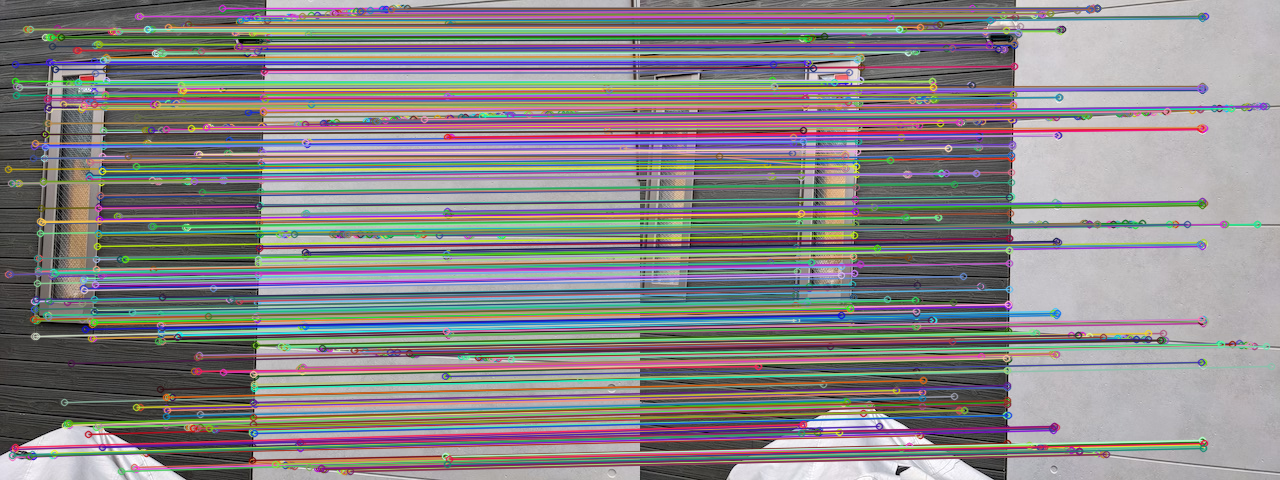

In [18]:
files = sorted(glob.glob('pair_images/pair_01/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


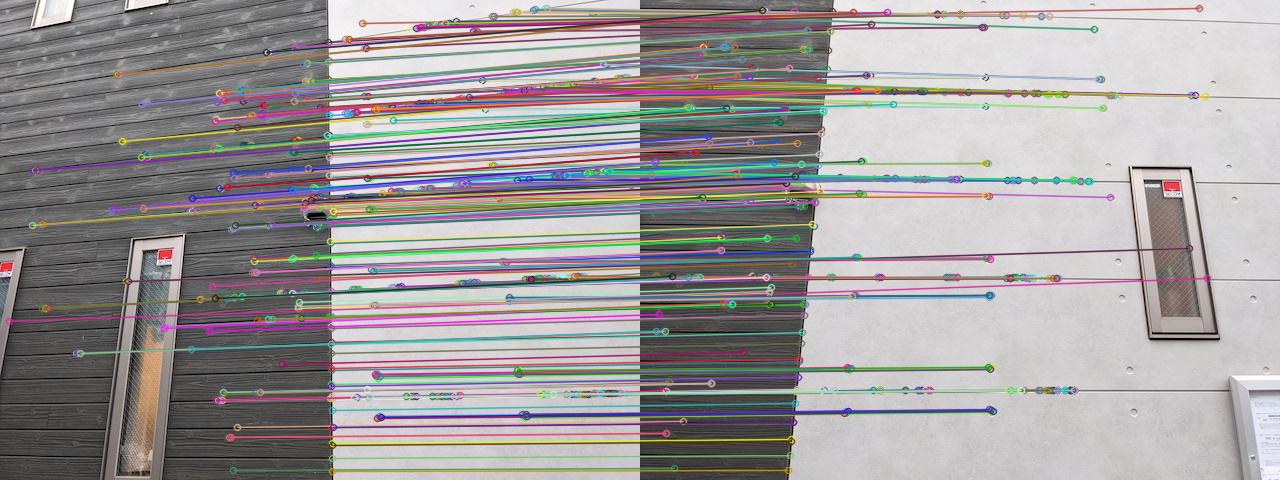

In [19]:
files = sorted(glob.glob('pair_images/pair_02/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


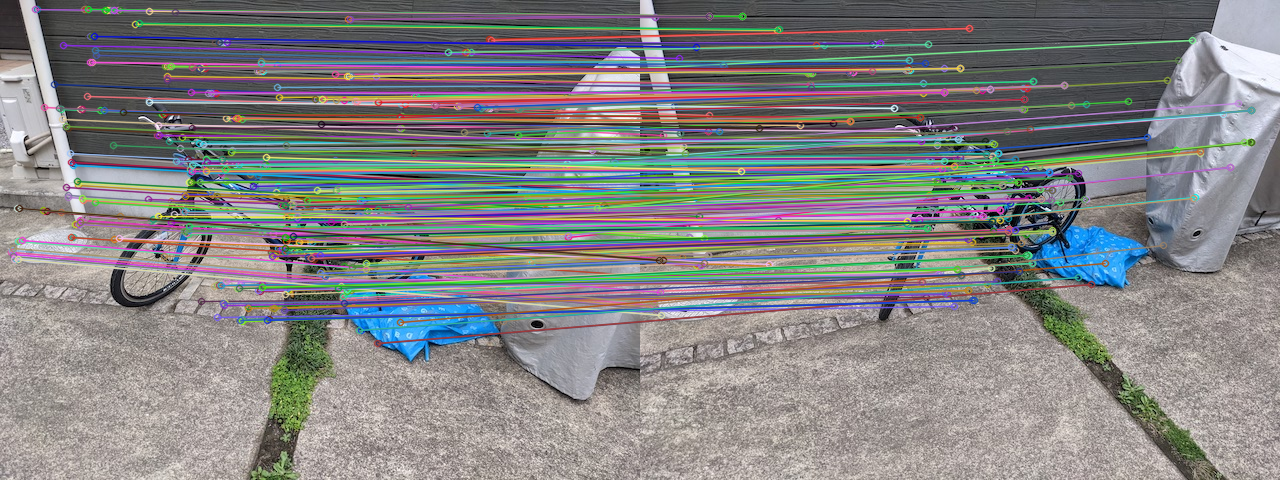

In [20]:
files = sorted(glob.glob('pair_images/pair_03/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


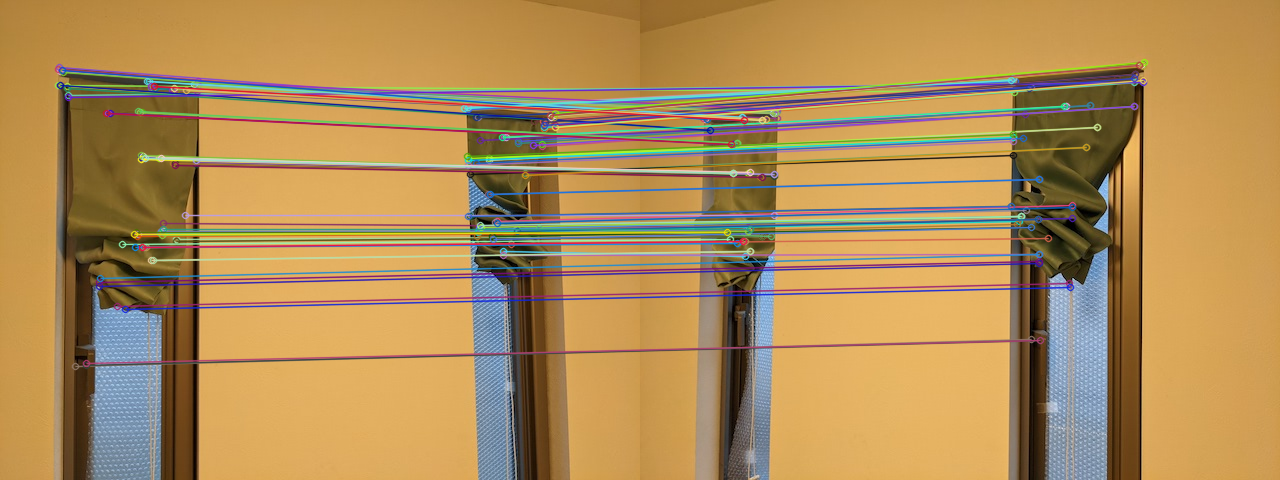

In [21]:
files = sorted(glob.glob('pair_images/pair_04/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


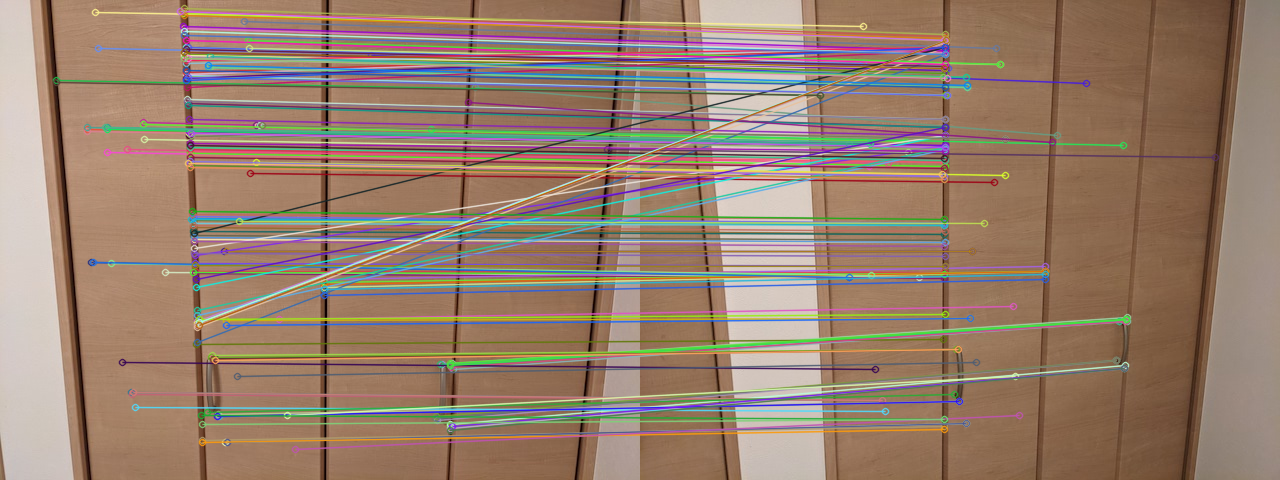

In [22]:
files = sorted(glob.glob('pair_images/pair_05/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


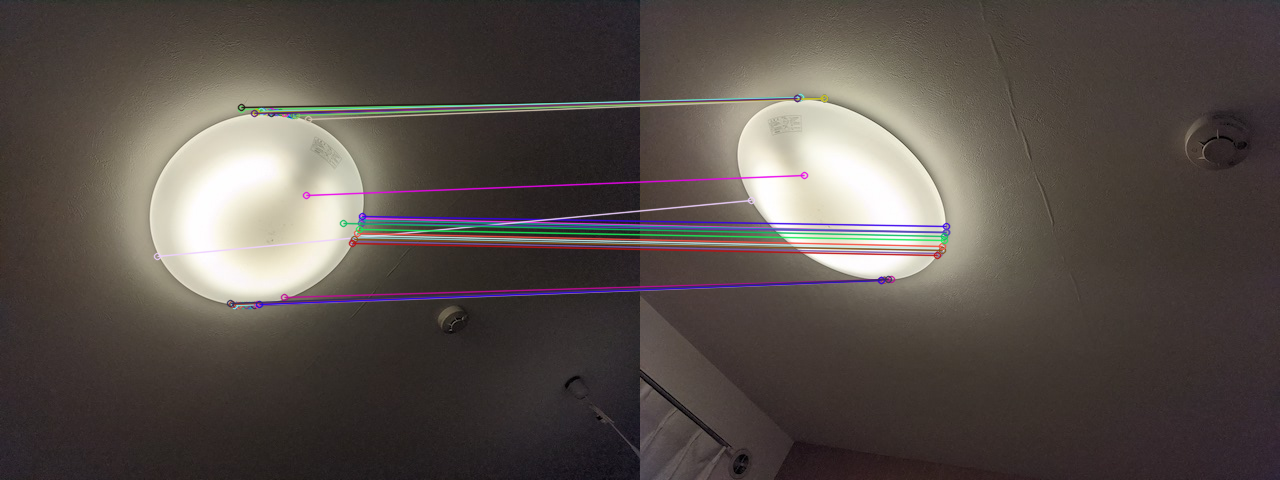

In [23]:
files = sorted(glob.glob('pair_images/pair_06/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


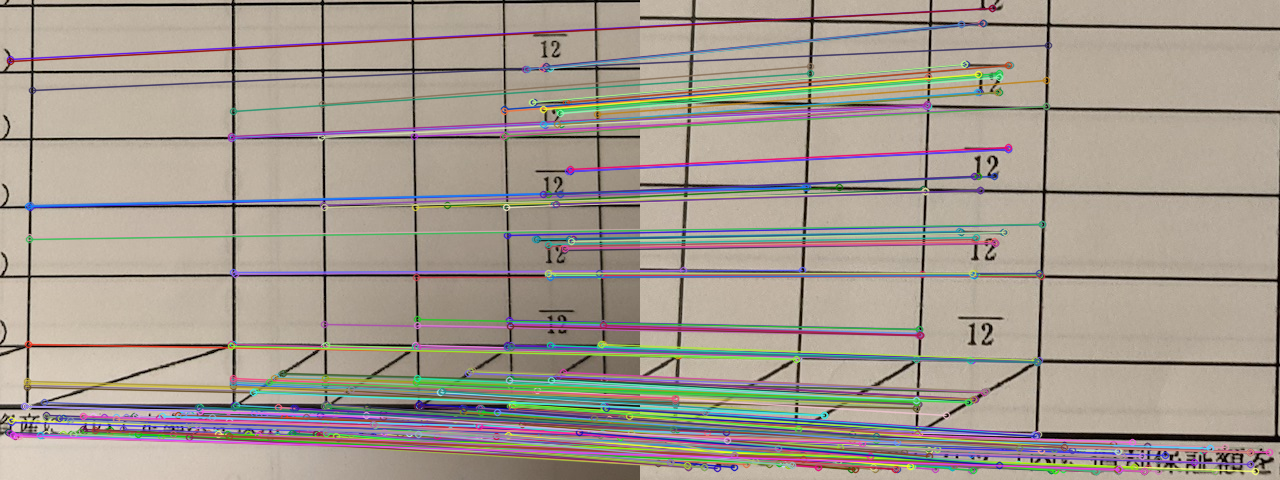

In [24]:
files = sorted(glob.glob('pair_images/pair_07/*.jpg'))

img1 = cv2.imread(files[0])
img2 = cv2.imread(files[1])

kp1, des1, kp2, des2 = getFeatures(img1, img2, fe)
good2 = find_fundamental_mat(kp1, des1, kp2, des2, img1.shape, img2.shape, model)

match_img_ngransac = cv2.drawMatches(img1, kp1, img2, kp2, good2, None, flags=2)
Image.fromarray(cv2.cvtColor(match_img_ngransac, cv2.COLOR_BGR2RGB))